In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
# import pyfftw.builders as fft
import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import scipy as sp
import scipy.integrate as integrate
import scipy.signal as signal
import seaborn as sns
from functools import partial
from matplotlib.collections import PatchCollection
from matplotlib.patches import Wedge
from mpmath import quadosc
from mpmath import findroot
from pyem import algo
from pyem import ctf
from pyem import geom
from pyem import mrc
from pyem import star
from pyem import vop
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

%matplotlib inline
sns.set()
pyfftw.interfaces.cache.enable()

pd.options.display.max_colwidth = 500

In [2]:
@numba.jit(cache=True, nopython=True, nogil=True)
def eval_ctfs(s, a, def1, def2, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0):
    ctfs = np.zeros((len(def1), s.shape[0], s.shape[1]), dtype=def1.dtype)
    for i in numba.prange(len(def1)):
        ctfs[i] = ctf.eval_ctf(s, a, def1, def2, angast=angast, phase=phase, kv=kv, ac=ac, cs=cs, bf=bf, lp=lp)
    return ctfs

In [3]:
def envelope(s, a, def1, def2, angast=0, kv=300, cs=2.0, q0=0.0143):
    angast = np.deg2rad(angast)
    kv = kv * 1e3
    cs = cs * 1e7
    lamb = 12.2643247 / np.sqrt(kv * (1. + kv * 0.978466e-6))
    f = s * np.power(cs * lamb**3, 0.25)
    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5
    dz = def_avg + def_dev * (np.cos(2 * (a - angast)))
    z = dz / np.sqrt(cs * lamb)
    amp = np.exp(-(np.pi * q0 * f * (f**2 - z))**2)
    return amp

In [4]:
@numba.jit(cache=True, nopython=True, nogil=True)
def nikvelope(s, a, def1, def2, angast=0, kv=300, cs=2.0, ai=0.000050):
    angast = np.deg2rad(angast)
    kv = kv * 1e3
    cs = cs * 1e7
    lamb = 12.2643247 / np.sqrt(kv * (1. + kv * 0.978466e-6))
    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5
    dz = def_avg + def_dev * (np.cos(2 * (a - angast)))
    amp = np.exp(-(np.pi * ai * (cs * lamb**2 * s**3 - dz * s))**2 / np.log(2))
    return amp

In [5]:
@numba.jit(cache=True, nopython=True, nogil=True)
def temporal_coherence_envelope(s, de, kv=300, cc=2.0):
    kv = kv * 1e3
    cc = cc * 1e7
    lamb = 12.2643247 / np.sqrt(kv * (1. + kv * 0.978466e-6))
    amp = np.exp(-(np.pi * lamb * s**2 * cc * de / (4 * kv * np.sqrt(np.log(2))))**2)
    return amp

In [6]:
@numba.jit(cache=True, nopython=True, nogil=True)
def mtf(s, a, b, alpha, beta, c=0):
    s2 = s**2
    return a / (1 + alpha * s2) + b / (1 + beta * s2) + c

In [7]:
@numba.jit(cache=True, nopython=True, nogil=True)
def critical(s):
    a = 0.245
    b = -1.665
    c = 2.81
    return a * s**b + c

In [8]:
@numba.jit(cache=True, nopython=True, nogil=True)
def dose_decay(s, n):
    ne = 2 * critical(s)
    return np.exp(-n / ne)

In [9]:
window = 1024
apix = 1.0
kv = 300
cs = 2.7
cc = 2.7
ac = 0.07
phase = 0
mtf_a = 0.463
mtf_b = 0.491
mtf_alpha = 5.143
mtf_beta = 5.143

In [12]:
lamb = 12.2643247 / np.sqrt(kv*1e3 * (1. + kv*1e3 * 0.978466e-6))
scherz = np.sqrt(4 * cs*1e7 * lamb / 4)
print("Scherzer defocus is %f" % scherz)

Scherzer defocus is 729.085464


In [13]:
# whalf = window // 2 - 1
sx, sy = np.meshgrid(np.fft.rfftfreq(window), np.fft.fftfreq(window))
s = np.sqrt(sx ** 2 + sy ** 2)
sr = s * window
# rmin = loreslim * apix * window
# rmax = hireslim * apix * window
# err_mask = ((s*window) >= rmin) & ((s*window) <= rmax)
sr = np.round(sr).astype(np.int64)
sr[sr > window // 2] = window // 2 + 1
nr = np.max(sr) + 1
sang = np.arctan2(sy, sx)
sa = s / apix
# psdlim = ps_est[err_mask]

In [14]:
def1 = 10000
def2 = 10000
angast = 0
ai = 5e-5
de = 0.7

In [15]:
c = ctf.eval_ctf(s, sang, def1, def2, angast=angast, kv=kv, cs=cs, ac=ac)

In [16]:
a = nikvelope(sa, sang, def1, def2, angast=angast, kv=kv, cs=cs, ai=ai)

In [17]:
a_temporal = temporal_coherence_envelope(sa, de, kv=kv, cc=cc)

In [19]:
m = mtf(s, mtf_a, mtf_b, mtf_alpha, mtf_beta)

In [21]:
d = dose_decay(s, 10)

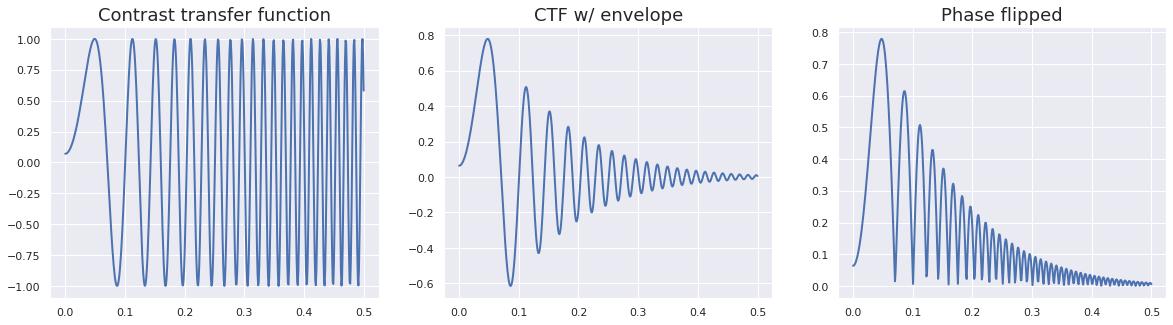

In [22]:
f, ax = plt.subplots(1, 3, figsize=(20,5))
# sns.set(font_scale=1)
# ax[0].plot(1/sa[0], a[0])
# ax[0].set_xlim((20, 1.5))
# ax[1].plot(1/sa[0], c[0])
# ax[1].set_xlim((30, 1.5))
env = m[0] * d[0] * a[0] * a_temporal[0] * m[0]
ax[0].set_title("Contrast transfer function", fontsize=18)
ax[0].plot(s[0], c[0], linewidth=2)
ax[1].set_title("CTF w/ envelope", fontsize=18)
ax[1].plot(s[0], c[0] * env, linewidth=2)
ax[2].set_title("Phase flipped", fontsize=18)
ax[2].plot(s[0], np.abs(c[0] * env), linewidth=2)


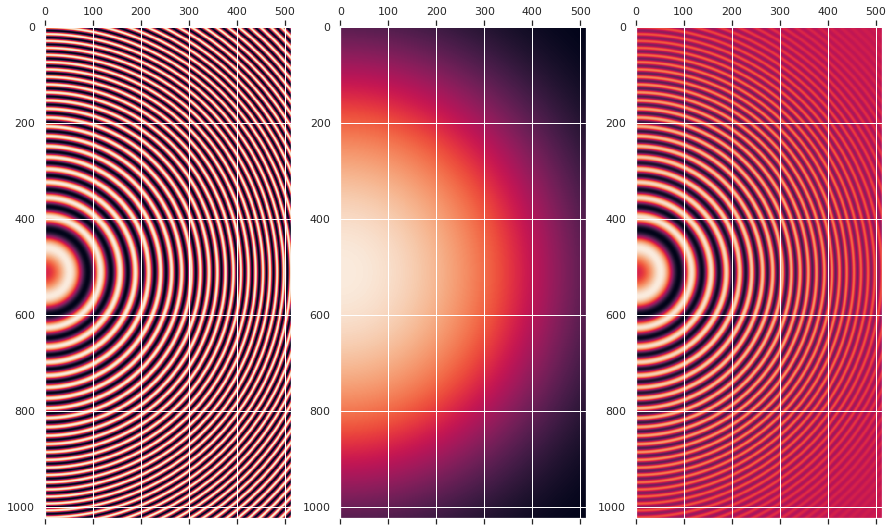

In [458]:
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].matshow(fft.fftshift(c, axes=0))
ax[1].matshow(fft.fftshift(a,axes=0))
ax[2].matshow(fft.fftshift(c*a,axes=0))

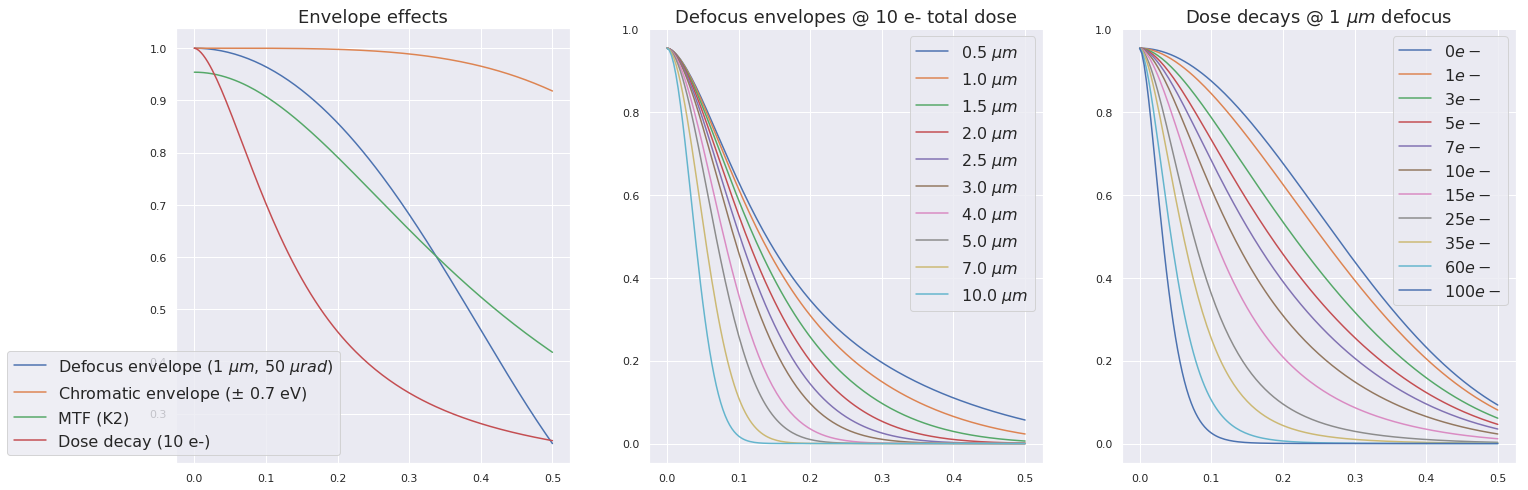

In [1076]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 3, figsize=(24,8))

ax[0].set_title("Envelope effects", fontsize=18)
ax[0].plot(s[0], a[0])
ax[0].plot(s[0], a_temporal[0])
ax[0].plot(s[0], m[0])
ax[0].plot(s[0], d[0])
ax[0].legend(["Defocus envelope (%d $\mu m$, %0.0f $\mu rad$)" % (def1/1e4, ai*1e6),
              "Chromatic envelope ($\pm$ %0.1f eV)" % de,
              "MTF (K2)",
              "Dose decay (10 e-)"],
            loc="lower left", bbox_to_anchor=(-0.45,0), fontsize=16)

ax[1].set_title("Defocus envelopes @ 10 e- total dose", fontsize=18)
# dzs = np.arange(5000, 32500, 2500)
dzs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 7, 10]
for dz in dzs:
    ax[1].plot(s[0], m[0] * nikvelope(sa[0], sang[0], dz*1e4, dz*1e4, kv=kv, cs=cs, ai=ai) * a_temporal[0] * d[0])
ax[1].legend([r"%0.1f $\mu m$" % (dz) for dz in dzs], fontsize=16)

ax[2].set_title("Dose decays @ 1 $\mu m$ defocus", fontsize=18)
# nes = np.arange(0,110,10)
# nes[0] = 1
nes = [0, 1, 3, 5, 7, 10, 15, 25, 35, 60, 100]
for ne in nes:
    ax[2].plot(s[0], m[0] * a[0] * a_temporal[0] * dose_decay(s[0], ne))
ax[2].legend([r"$%d e-$" % (ne) for ne in nes], fontsize=16)
# plt.xlim((0,0.5))
# plt.plot(1/sa[0], m[0])
# plt.xlim((15, 0))

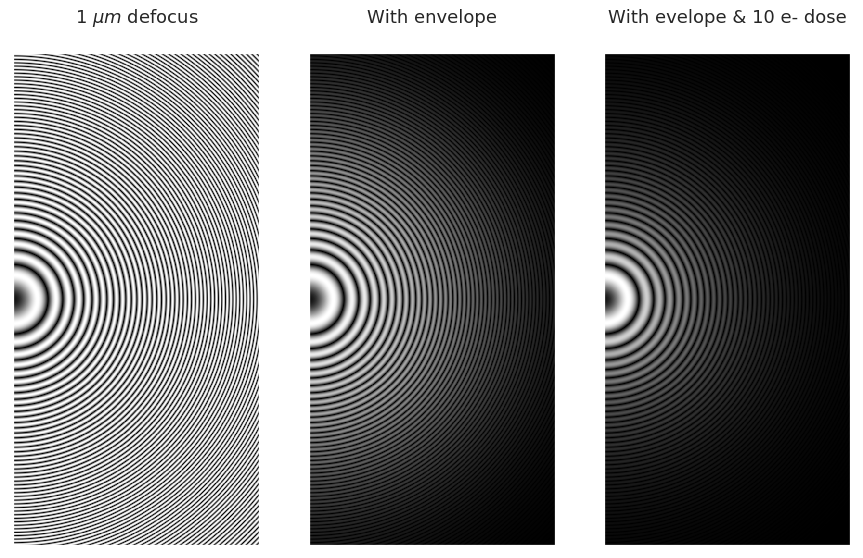

In [661]:
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].set_title("1 $\mu m$ defocus", fontsize=18)
ax[0].matshow(np.abs(fft.fftshift(c, axes=0)), cmap="gray")
ax[1].set_title("With envelope", fontsize=18)
ax[1].matshow(np.abs(fft.fftshift(c*m*a, axes=0)), cmap="gray")
ax[2].set_title("With evelope & 10 e- dose", fontsize=18)
ax[2].matshow(np.abs(fft.fftshift(c*m*a*d,axes=0)), cmap="gray")
for _a in ax:
    _a.grid(False)
    _a.set_xticks([])
    _a.set_yticks([])
    _a.set_xticklabels([])
    _a.set_yticklabels([])

In [1452]:
@numba.jit(cache=True, nopython=True, nogil=True)
def ctf_ifunc1d(s, defocus, phase_flip=True,
               kv=kv, cs=cs, ac=ac, phase=phase):
    sa = s / apix
    a = nikvelope(sa, 0, defocus, defocus, kv=kv, cs=cs, ai=ai)
    a_temp = temporal_coherence_envelope(sa, de, kv=kv, cc=cs)
    m = mtf(s, mtf_a, mtf_b, mtf_alpha, mtf_beta)
    c = ctf.eval_ctf(s, 0, defocus, defocus, kv=kv, cs=cs, ac=ac, phase=phase)
    if phase_flip:
        return np.abs(a * a_temp * m * c)
    else:
        return a * a_temp * m * c
#     return np.abs(c)

In [490]:
list(range(0,1))

[0]

In [1453]:
def ctf_ifunc1d_dose(s, defocus, ne, initial=0, phase_flip=True,
                    kv=kv, cs=cs, ac=ac, phase=phase):
    c = ctf_ifunc1d(s, defocus, phase_flip=phase_flip, kv=kv, cs=cs, ac=ac, phase=phase)
    d = np.zeros_like(c)
    for i in range(ne):
        d += dose_decay(s, initial + i + 1)
#         cd += c * d
#     cd /= (ne + initial)
    return c * d

In [629]:
def ctf_ifunc1d_dose_quad(s, defocus, ne, initial=0):
    c = ctf_ifunc1d(s, defocus)
    d = np.zeros_like(s)
    for i in range(len(s)): 
        _dose_decay = lambda x: dose_decay(s[i], x)
        d[i], err = integrate.quad(_dose_decay, initial, ne + initial, full_output=0, limit=500)
#     cd = c * d * ne
    cd = c * d
    return cd

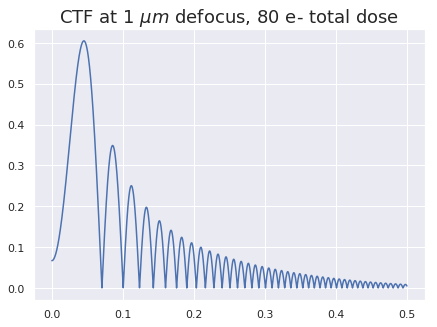

In [659]:
f, ax = plt.subplots(1, 1, figsize=(7,5))
# plt.plot(s[0], ctf_ifunc1d_dose(s[0], def1, 1, 0))
ax.set_title("CTF at %d $\mu m$ defocus, 80 e- total dose" % (def1 * 1e-4), fontsize=18)
# ax.plot(space, ctf_ifunc1d_dose(space, def1, 1, initial=0)*1/80)
# ax.plot(space, ctf_ifunc1d_dose_quad(space, def1, 1, initial=1)*1/80)
# ax.plot(space, ctf_ifunc1d_dose(space, def1, 1, initial=1)*1/80)
# ax.plot(space, ctf_ifunc1d_dose_quad(space, def1, 1, initial=1)*1/80)
# ax.plot(space, ctf_ifunc1d_dose(space, def1, 1, initial=79)*1/80)
# ax.plot(space, ctf_ifunc1d_dose_quad(space, def1, 1, initial=79)*1/80)
ax.plot(space, ctf_ifunc1d_dose_quad(space, def1, 80, initial=0)*1/80)
# print np.sqrt(np.mean((ctf_ifunc1d_dose_quad(s[0], def1, 50) - ctf_ifunc1d_dose(s[0], def1, 50))**2))

In [120]:
def ctf_ifunc1d_2d(s, ne, defocus):
    return ctf_ifunc1d(s, defocus) * dose_decay(s, ne)

In [228]:
val, err = integrate.quadrature(ctf_ifunc1d, 0, 0.5, args=(def1,), maxiter=5000)

In [229]:
print "%0.6f within %0.12f" % (val, err)

0.313130 within 0.000000009155


In [250]:
val_env, err_env = integrate.quadrature(ctf_ifunc1d, 0, 0.5, args=(def1,), maxiter=5000)

In [251]:
print "%0.6f within %0.12f" % (val_env, err_env)

0.119450 within 0.000000008091


In [321]:
res = integrate.quad(ctf_ifunc1d, 0, 0.5, args=(def1,), full_output=1, limit=1000)

In [319]:
print res[0], res[1]
print res[-1]

0.115953551687 1.11596624652e-05
1.11596624652e-05


In [279]:
integrate.nquad(ctf_ifunc1d_2d, [[0, 0.5], [0, 50]], args=(def1,), opts={"limit": 1000})

(2.8142428645252147, 1.4157373194295664e-05)

In [257]:
integrate.romb(ctf_ifunc1d(s[0], def1), dx=1.0/len(s[0]))

0.23153596502627707

In [171]:
val_env_dose, err_env_dose = integrate.dblquad(ctf_ifunc1d_2d,
                                               0, 0.5,
                                               lambda x: 0,
                                               lambda x: 50,
                                               args=(def1,))

In [172]:
val_env_dose

0.059236882095638335

In [454]:
val_ = np.zeros_like(s[0])
for i, si_ in enumerate(s[0]):
    val_[i], err_ = integrate.quadrature(lambda x: ctf_ifunc1d_2d(si_, x, def1), 0, 50, maxiter=500)

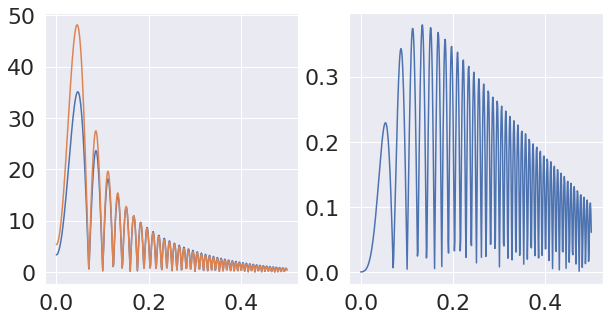

In [918]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(s[0], val_)
ax[0].plot(s[0], ctf_ifunc1d_dose(s[0], def1, 80))
ax[1].plot(s[0], np.sqrt(((val_ - ctf_ifunc1d_dose(s[0], def1, 50))**2)))

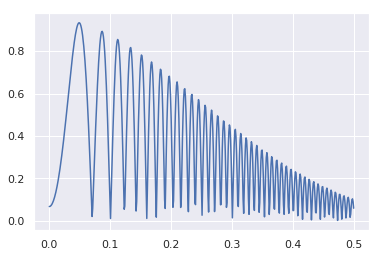

In [499]:
plt.plot(s[0], ctf_ifunc1d_2d(s[0], 0, def1))

/home/da/local/miniconda2/envs/my2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.03, 0.05)

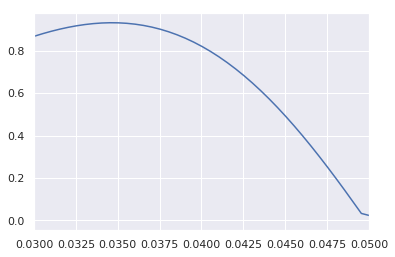

In [142]:
plt.plot(np.linspace(0.0, 0.5, 1e3), ctf_ifunc1d(np.linspace(0.0, 0.5, 1e3), def1))
plt.xlim((0.03, 0.05))

In [284]:
print np.sum(fft.irfft(ctf_ifunc1d(s[0], def1))) * 2
print np.sum(fft.irfft(ctf_ifunc1d(s[0], def1), n=1)) * 2
print np.sum(ctf_ifunc1d(s[0], def1)) / len(s[0]) / 2
print np.sum(ctf_ifunc1d(space, def1)) / len(space) / 2
print integrate.simps(ctf_ifunc1d(s[0], def1), s[0])
print integrate.trapz(ctf_ifunc1d(s[0], def1), s[0])
print integrate.trapz(ctf_ifunc1d(space, def1), space)
print integrate.romb(ctf_ifunc1d(s[0], def1), dx=1.0/len(s[0]))

0.13356000000000004
0.13356
0.1158603499423235
0.11594357017272905
0.11601613426437371
0.11605388550849481
0.11595348850757356
0.23153596502627707


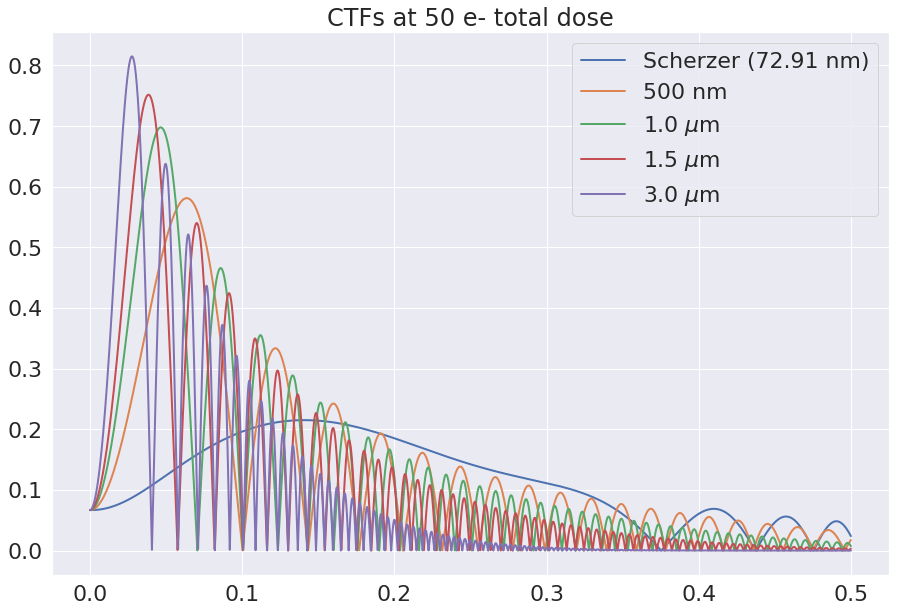

In [678]:
f, ax = plt.subplots(1, figsize=(15,10))
sns.set(font_scale=2)
plt.title("CTFs at 50 e- total dose")
plt.plot(space, ctf_ifunc1d_dose(space, scherz, 50) / 50, linewidth=2)
plt.plot(space, (ctf_ifunc1d_dose(space, 5000, 50)) / 50, linewidth=2)
plt.plot(space, (ctf_ifunc1d_dose(space, 10000, 50)) / 50, linewidth=2)
ax.plot(space, (ctf_ifunc1d_dose(space, 15000, 50)) / 50, linewidth=2)
ax.plot(space, (ctf_ifunc1d_dose(space, 30000, 50)) / 50, linewidth=2)
ax.legend(["Scherzer (%0.2f nm)" % (scherz*1e-1),
           "500 nm", "1.0 $\mu$m", "1.5 $\mu$m", "3.0 $\mu$m"])

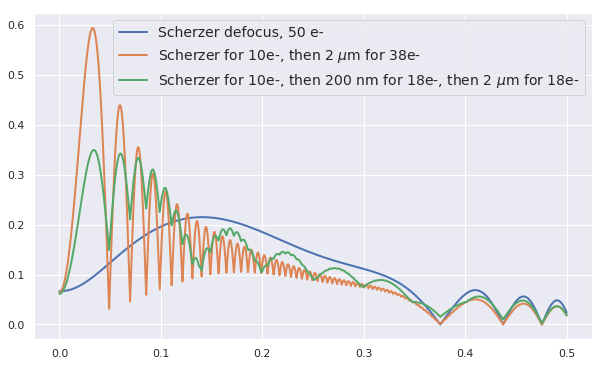

In [851]:
f, ax = plt.subplots(1, figsize=(10,6))
plt.plot(space, ctf_ifunc1d_dose(space, scherz, 50) / 50, linewidth=2)
plt.plot(space, (ctf_ifunc1d_dose(space, scherz, 10) + ctf_ifunc1d_dose(space, scherz + 20000, 38, 12)) / 50, linewidth=2)
ax.plot(space, (ctf_ifunc1d_dose(space, scherz, 10) + ctf_ifunc1d_dose(space, scherz + 2000, 18, 12) + ctf_ifunc1d_dose(space, scherz + 20000, 18, 32)) / 50, linewidth=2)
plt.legend(["Scherzer defocus, 50 e-", "Scherzer for 10e-, then 2 $\mu$m for 38e-", "Scherzer for 10e-, then 200 nm for 18e-, then 2 $\mu$m for 18e-"], fontsize=14)

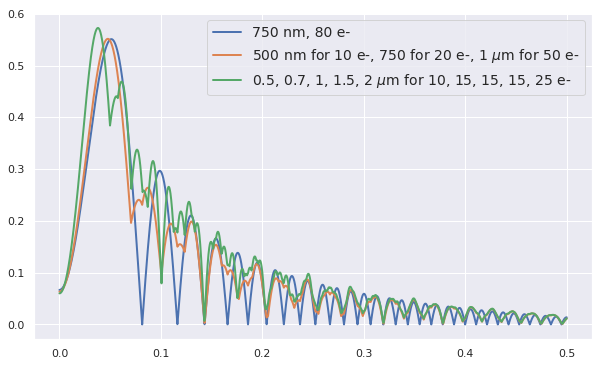

In [854]:
f, ax = plt.subplots(1, figsize=(10,6))
plt.plot(space, defocus_series(space, [7500], [80]), linewidth=2)
plt.plot(space, defocus_series(space, [5000, 7500, 10000], [10, 20, 50]), linewidth=2)
plt.plot(space, defocus_series(space, [5000, 7500, 10000, 15000, 20000], [10, 15, 15, 15, 25]), linewidth=2)
plt.legend(["750 nm, 80 e-", "500 nm for 10 e-, 750 for 20 e-, 1 $\mu$m for 50 e-", "0.5, 0.7, 1, 1.5, 2 $\mu$m for 10, 15, 15, 15, 25 e-"], fontsize=14)

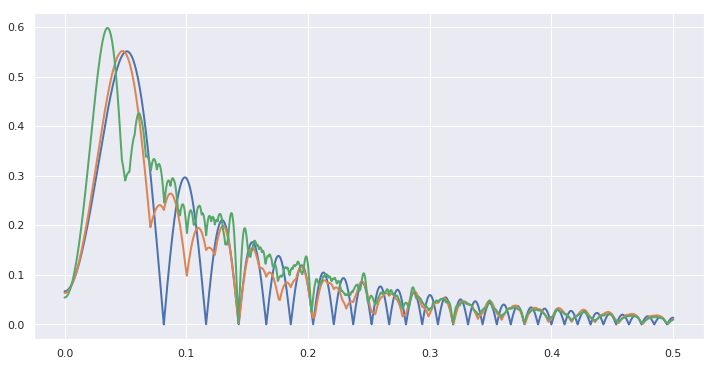

In [843]:
f, ax = plt.subplots(1, figsize=(12,6))
plt.plot(space, defocus_series(space, [7500], [80]), linewidth=2)
plt.plot(space, defocus_series(space, [5000, 7500, 10000], [10, 20, 50]), linewidth=2)
plt.plot(space, defocus_series(space, [5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500], [5, 5, 5, 5, 10, 15, 15, 15]), linewidth=2)



In [785]:
def defocus_series(s, defocus, dose):
    c = ctf_ifunc1d_dose_quad(s, defocus[0], dose[0])
    for i in range(1, len(defocus)):
#         c += ctf_ifunc1d_dose(s, defocus[i], dose[i] - 2, initial=dose[i-1] + 2)
        c += ctf_ifunc1d_dose_quad(s, defocus[i], dose[i] - 2, initial=dose[i-1] + 2)
    c /= np.sum(dose)
    return c

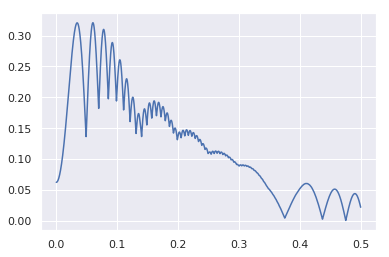

In [352]:
plt.plot(space, defocus_series(space, [scherz, scherz + 2000, scherz + 20000], [20, 20, 20]))

In [353]:
def target(params):
    return integrate.trapz(defocus_series(space, params[:len(params)/2], params[len(params)/2:]), space)

In [371]:
x0 = np.array([5000, 10000, 20000] + [10, 20, 30])

In [373]:
bounds = [(500, 50000)]*3 + [(0, 60)]*3

In [374]:
constraints = NonlinearConstraint(lambda x: np.sum(x[len(x)/2:]), 0, 60)

In [375]:
res = minimize(target, x0, bounds=bounds, constraints=constraints, method='trust-constr', options={"maxiter": 250})

In [376]:
res

 barrier_parameter: 2.560000000000001e-07
 barrier_tolerance: 2.560000000000001e-07
          cg_niter: 822
      cg_stop_cond: 4
            constr: [array([59.99763874]), array([5.00095230e+03, 6.74572506e+03, 3.24433679e+04, 7.91814735e-05,
       1.95426397e-04, 5.99973641e+01])]
       constr_nfev: [1701, 0]
       constr_nhev: [0, 0]
       constr_njev: [0, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 913.3114049434662
               fun: 0.03458622163582894
              grad: array([-8.75276520e-12,  1.63484355e-07, -5.42786097e-07,  3.11485492e-03,
        1.78255979e-03, -1.43537193e-04])
               jac: [array([[0., 0., 0., 1., 1., 1.]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])]
   lagrangian_grad: array([-5.99406054e-11,  1.63449281e-07, -5.42779528e-07, -2.87400746e-13,
        2.0813919

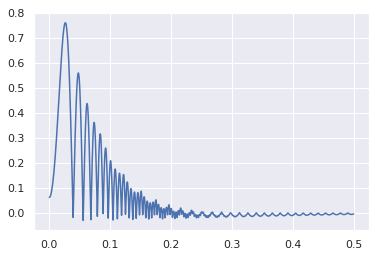

In [377]:
plt.plot(space, defocus_series(space, res.x[:len(res.x)/2], res.x[len(res.x)/2:]))

In [703]:
m4, hdr = mrc.read("/mnt/tyr-data/da/Documents/Projects/TRPM4/CaCl2/Cryosparc/cryosparc_exp000410_013.mrc", inc_header=True, compat="relion")
msk, hdr = mrc.read("/mnt/tyr-data/da/Documents/Projects/TRPM4/CaCl2/Cryosparc/cryosparc_exp000410_013_refinemask.mrc", inc_header=True, compat="relion")


In [1346]:
m4f = vop.vol_ft(m4, pfac=2, threads=8)

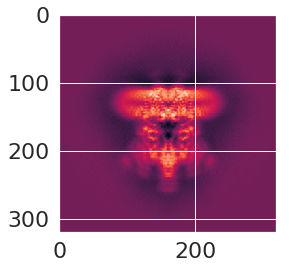

In [1334]:
plt.imshow(np.sum(m4, axis=2))

In [708]:
e = np.deg2rad([0, 90, 90])
rot = geom.euler2rot(*e)

In [759]:
p = vop.interpolate_slice_numba(m4f, rot, pfac=2)
h = fft.fftshift(fft.irfft2(p))

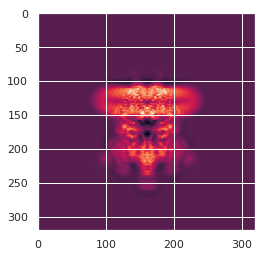

In [760]:
plt.imshow(h)

In [990]:
# whalf = window // 2 - 1
sx, sy = np.meshgrid(np.fft.rfftfreq(p.shape[0]), np.fft.fftfreq(p.shape[0]))
s = np.sqrt(sx ** 2 + sy ** 2)
sr = s * p.shape[0]
# rmin = loreslim * apix * window
# rmax = hireslim * apix * window
# err_mask = ((s*window) >= rmin) & ((s*window) <= rmax)
sr = np.round(sr).astype(np.int64)
sr[sr > p.shape[0] // 2] = p.shape[0] // 2 + 1
nr = np.max(sr) + 1
sang = np.arctan2(sy, sx)
sa = s / apix
# psdlim = ps_est[err_mask]

In [991]:
c = ctf.eval_ctf(s, sang, 30000, 30000, angast=angast, kv=kv, cs=cs, ac=ac)
a = nikvelope(sa, sang, def1, def2, angast=angast, kv=kv, cs=cs, ai=ai)
a_temporal = temporal_coherence_envelope(sa, de, kv=kv, cc=cs)
m = mtf(s, mtf_a, mtf_b, mtf_alpha, mtf_beta)
d = dose_decay(s, 10)

In [992]:
q = p * c * a * a_temporal * m * d

In [993]:
g = fft.fftshift(fft.irfft2(q))

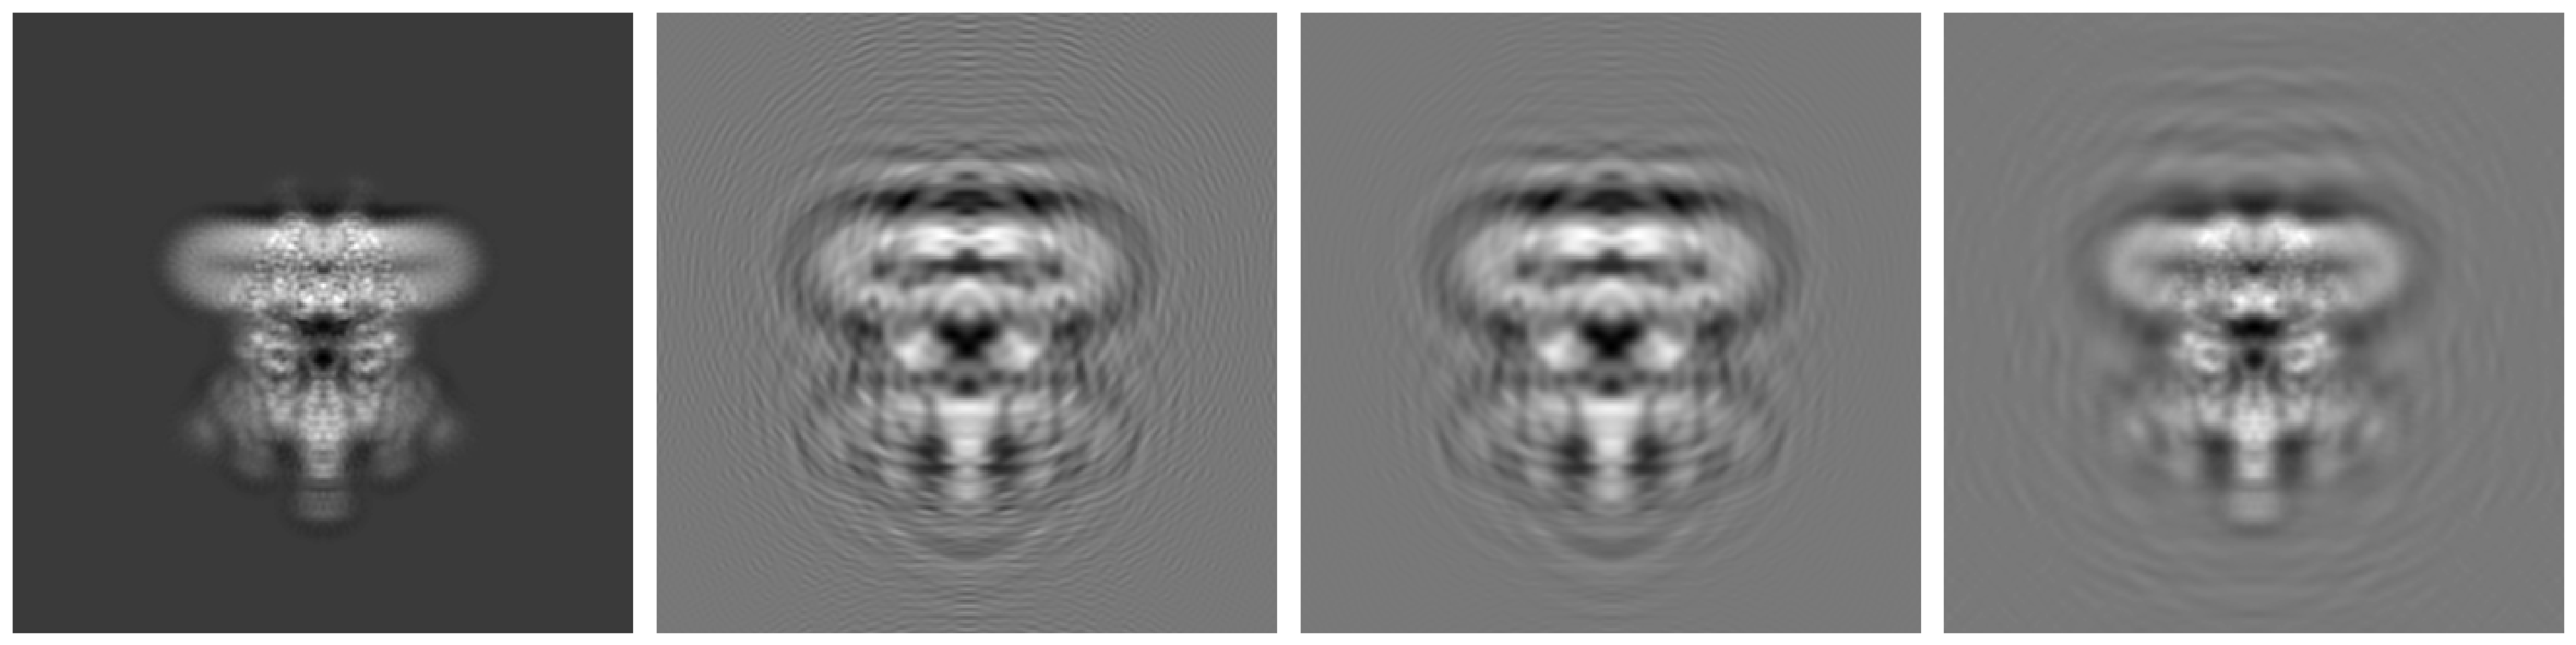

In [780]:
f, ax = plt.subplots(1, 4, figsize=(40,10))
ax[0].imshow(fft.fftshift(fft.irfft2(p)), cmap="gray")
ax[1].imshow(fft.fftshift(fft.irfft2(p * c)), cmap="gray")
ax[2].imshow(fft.fftshift(fft.irfft2(p * c * a * a_temporal * m * d)), cmap="gray")
ax[3].imshow(fft.fftshift(fft.irfft2(p * np.abs(c * a * a_temporal * m * d))), cmap="gray")
for _a in ax.flat:
    _a.grid(False)
    _a.set_xticks([])
    _a.set_yticks([])
f.tight_layout()

In [994]:
def dose_quad(s, ne, initial=0):
    sflat = s.reshape(-1)
    d = np.zeros_like(sflat)
    _dose_decay = lambda x, si: dose_decay(si, x)
    for i in range(len(sflat)): 
        d[i], err = integrate.quad(_dose_decay, initial, ne + initial, args=(sflat[i],), full_output=0, limit=500)
    return d.reshape(s.shape)

In [995]:
def defocus_series2d(s, defocus, dose):
    defind = temporal_coherence_envelope(sa, de, kv=kv, cc=cs)
    defind *= mtf(s, mtf_a, mtf_b, mtf_alpha, mtf_beta)
#     cout = np.zeros_like(s)
    cout = ctf.eval_ctf(s, sang, defocus[0], defocus[0], angast=angast, kv=kv, cs=cs, ac=ac)
    cout *= nikvelope(sa, sang, defocus[0], defocus[0], angast=angast, kv=kv, cs=cs, ai=ai)
    for i in range(1, len(defocus)):
        c = ctf.eval_ctf(s, sang, defocus[i], defocus[i], angast=angast, kv=kv, cs=cs, ac=ac)
        a = nikvelope(sa, sang, defocus[i], defocus[i], angast=angast, kv=kv, cs=cs, ai=ai)
        cout += np.abs(c) * a * dose_quad(s, dose[i] - 2, initial=dose[i-1] + 2)
    cout *= defind
    cout /= np.sum(dose)
    return cout

In [937]:
cout = defocus_series2d(s, [5000, 7500, 10000], [10, 20, 50])

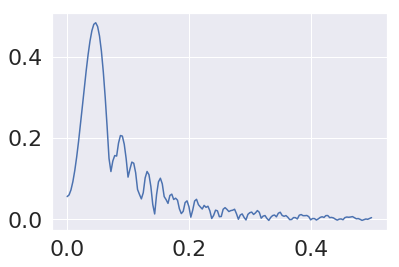

In [938]:
plt.plot(s[0], cout[0])

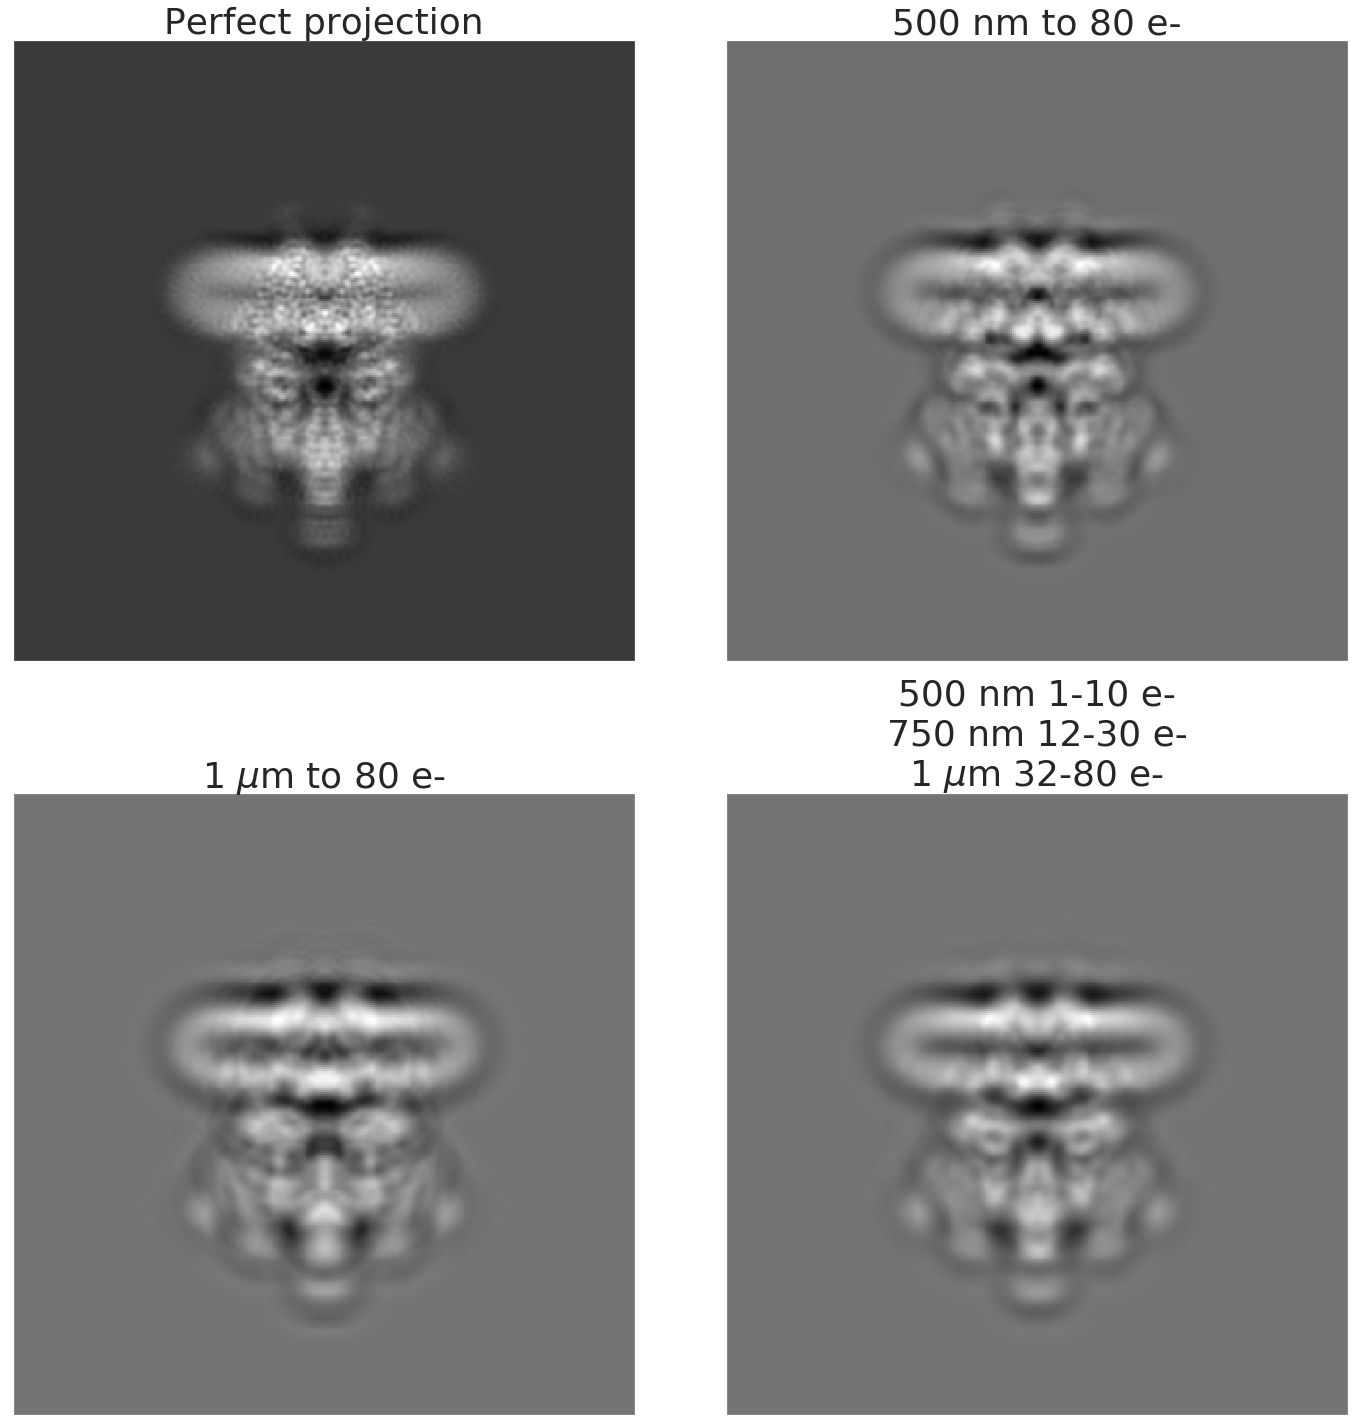

In [856]:
h = fft.fftshift(fft.irfft2(p))
vmin = None
vmax = None
f, ax = plt.subplots(2, 2, figsize=(20,20))
pfilt = p * m * a_temporal
g = fft.fftshift(fft.irfft2(pfilt))
ax[0,0].set_title("Perfect projection", fontsize=36)
ax[0,0].imshow(h, cmap="gray", vmin=vmin, vmax=vmax)
ax[0,1].set_title("500 nm to 80 e-", fontsize=36)
ax[0,1].imshow(fft.fftshift(fft.irfft2(pfilt * nikvelope(sa, sang, 5000, 5000, kv=kv, cs=cs, ai=ai) * ctf.eval_ctf(s, sang, 5000, 5000, kv=kv, cs=cs, ac=ac) * dose_quad(s, 80) / 80)), cmap="gray", vmin=vmin, vmax=vmax)
ax[1,0].set_title("1 $\mu$m to 80 e-", fontsize=36)
ax[1,0].imshow(fft.fftshift(fft.irfft2(pfilt * nikvelope(sa, sang, 10000, 10000, kv=kv, cs=cs, ai=ai) * ctf.eval_ctf(s, sang, 10000, 10000, kv=kv, cs=cs, ac=ac) * dose_quad(s, 80) / 80)), cmap="gray", vmin=vmin, vmax=vmax)
ax[1,1].set_title("500 nm 1-10 e-\n750 nm 12-30 e-\n1 $\mu$m 32-80 e-", fontsize=36)
ax[1,1].imshow(fft.fftshift(fft.irfft2(p * defocus_series2d(s, [5000, 7500, 10000], [10, 20, 50]))),
             cmap="gray", vmin=vmin, vmax=vmax)
for _a in ax.flat:
    _a.grid(False)
    _a.set_xticks([])
    _a.set_yticks([])
f.tight_layout()

In [823]:
print h.min(), h.max()
print g.min(), g.max()

-12.190842 40.749176
-14.935287323401468 17.156466744712397


In [1349]:
def compute_xc(ftc, rots, noisemag=None, c=None, lp=None, hp=None, p1=None):
    if p1 is None:
        p1 = vop.interpolate_slice_numba(ftc, rots[0])
    sx, sy = np.meshgrid(np.fft.rfftfreq(p1.shape[0]), np.fft.fftfreq(p1.shape[0]))
    s = np.sqrt(sx ** 2 + sy ** 2)
    xc = np.zeros(len(rots))
    for i in range(len(rots)):
        p2 = vop.interpolate_slice_numba(ftc, rots[i])
        if noisemag is not None:
            if np.isscalar(noisemag):
                p2 += np.random.randn(*p1.shape) * np.abs(p1) * noisemag
            else:
                p2 += noisemag
        if c is not None:
            p2 *= c
        p1p2 = p1 * np.conj(p2)
        if lp is not None:
            p1p2[s > lp] = 0. + 0*1j
        if hp is not None:
            p1p2[s < hp] = 0. + 0*1j
#         p1p2[0,0] = 0.
#         p1p2[0,1] = 0.
#         p1p2[1,0] = 0.
#         p1p2[-1,0] = 0.
        xc[i] = np.max(fft.irfft2(p1p2))
#         xc[i] = np.sum(fft.irfft2(p1p2))
#         xc[i] = fft.irfft2(p1p2)[0, 0]
#         pc[i] = np.max(fft.irfft2(p1p2 / (np.abs(p1p2) + 1e-17)))
#         tc[i] = np.max(fft.irfft2(p1 * p2 * np.conj(p1 + p2)))
    return xc

In [1352]:
m4noisy = m4 + 150 * np.std(m4 * msk) * np.random.randn(*m4.shape)
m4noisyf = vop.vol_ft(m4noisy, pfac=2, threads=8)

In [1365]:
# angles = np.arange(-45,225)
# rots = [geom.euler2rot(*(np.deg2rad(np.array([15,90,i])))) for i in angles]
angles = np.arange(-60,60)
rots = [geom.euler2rot(*np.deg2rad([i,90,0])) for i in angles]
noisemag = 200
# nois = np.random.randn(*p.shape) * np.abs(np.mean(vop.interpolate_slice_numba(m4f, rots[45]))) * noisemag
# noisr = fft.irfft2(nois)
p = vop.interpolate_slice_numba(m4f, rots[30], pfac=2)


In [1386]:
pavg = algo.bincount_nb(sr, p, out=np.zeros(nr, dtype=p.dtype))

In [1400]:
noisrad = np.random.randn(*pavg.shape) * 10

In [1405]:
nois = pavg[sr] * np.random.randn(*p.shape)

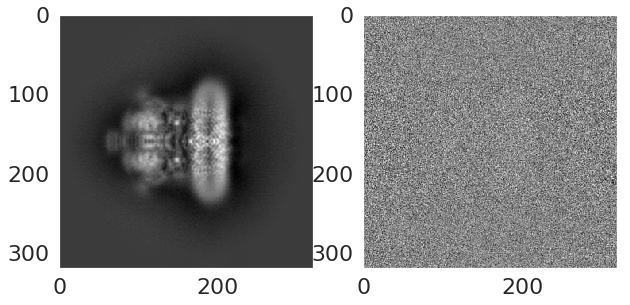

In [1406]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(fft.fftshift(fft.irfft2(p)), cmap="gray")
ax[1].imshow(fft.fftshift(fft.irfft2(
    vop.interpolate_slice_numba(m4noisyf, rots[30], pfac=2))), cmap="gray")
for _a in ax:
    _a.grid(False)

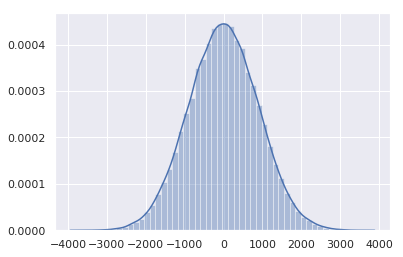

In [1097]:
sns.distplot(nois.flat)

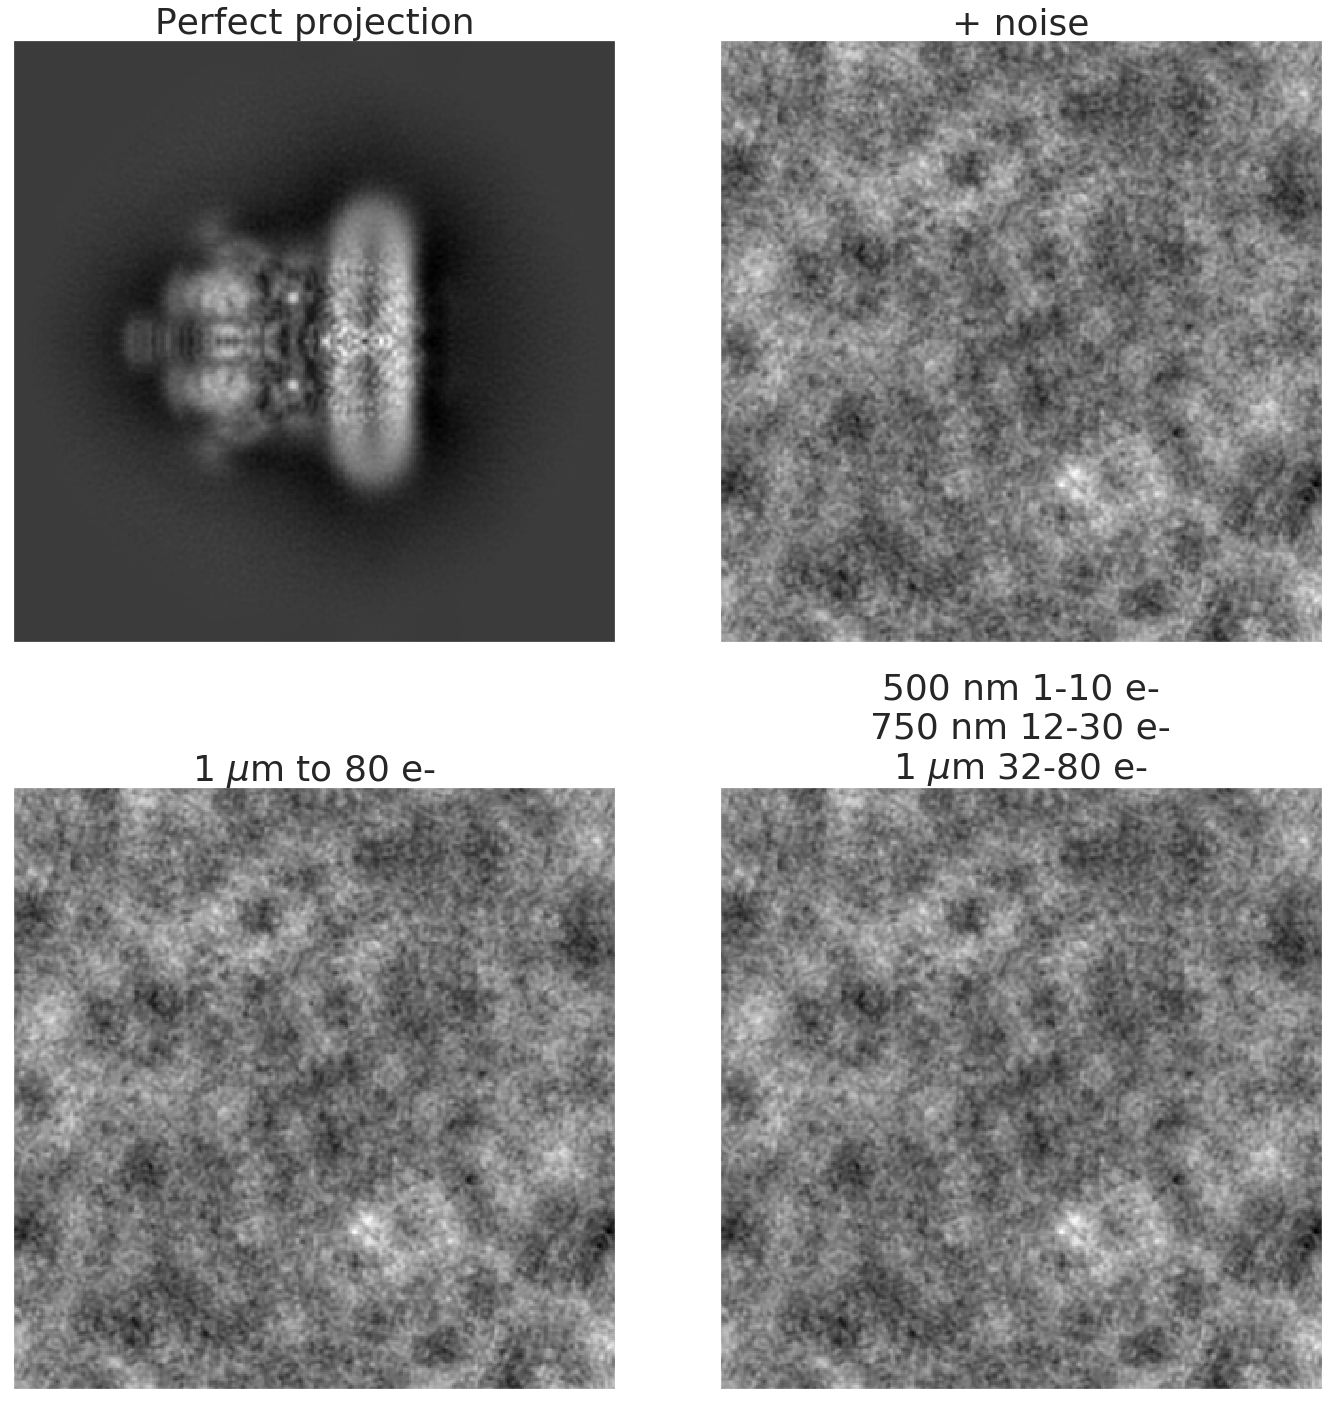

In [1407]:
h = fft.fftshift(fft.irfft2(p))
vmin = None
vmax = None
f, ax = plt.subplots(2, 2, figsize=(20,20))
pfilt = p * m * a_temporal
g = fft.fftshift(fft.irfft2(pfilt))
ax[0,0].set_title("Perfect projection", fontsize=36)
ax[0,0].imshow(h, cmap="gray", vmin=vmin, vmax=vmax)
ax[0,1].set_title("+ noise", fontsize=36)
ax[0,1].imshow(fft.fftshift(fft.irfft2(nois + pfilt * nikvelope(sa, sang, 5000, 5000, kv=kv, cs=cs, ai=ai) * ctf.eval_ctf(s, sang, 5000, 5000, kv=kv, cs=cs, ac=ac) * dose_quad(s, 80) / 80)), cmap="gray", vmin=vmin, vmax=vmax)
ax[1,0].set_title("1 $\mu$m to 80 e-", fontsize=36)
ax[1,0].imshow(fft.fftshift(fft.irfft2(nois + pfilt * nikvelope(sa, sang, 10000, 10000, kv=kv, cs=cs, ai=ai) * ctf.eval_ctf(s, sang, 10000, 10000, kv=kv, cs=cs, ac=ac) * dose_quad(s, 80) / 80)), cmap="gray", vmin=vmin, vmax=vmax)
ax[1,1].set_title("500 nm 1-10 e-\n750 nm 12-30 e-\n1 $\mu$m 32-80 e-", fontsize=36)
ax[1,1].imshow(fft.fftshift(fft.irfft2(nois + p * defocus_series2d(s, [5000, 7500, 10000], [10, 20, 50]))),
             cmap="gray", vmin=vmin, vmax=vmax)
for _a in ax.flat:
    _a.grid(False)
    _a.set_xticks([])
    _a.set_yticks([])
f.tight_layout()

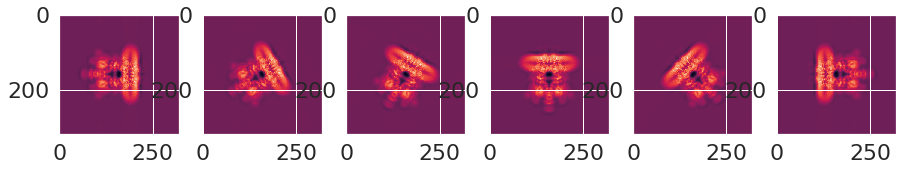

In [1003]:
f, ax = plt.subplots(1, 6, figsize=(15,5))
ax[0].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[45]))))
ax[1].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[75]))))
ax[2].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[105]))))
ax[3].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[135]))))
ax[4].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[180]))))
ax[5].imshow(fft.fftshift(fft.irfft2(vop.interpolate_slice_numba(m4f, rots[225]))))

In [1336]:
xc_clean = compute_xc(m4f, rots, 320)

Text(0.5,0,u'$\\psi$ (deg)')

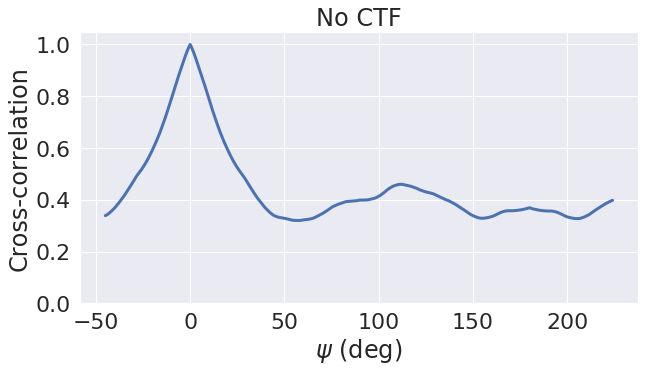

In [1337]:
sns.set(font_scale=2)
f, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(angles, xc_clean / np.max(xc_clean), linewidth=3)
# ax.plot(angles, xcl / np.max(xcl), linewidth=3)
# ax.plot(a,xc[:,2] / np.max(xc[:,0,]))
ax.set_title("No CTF")
ax.set_ylim((0.,1.05))
ax.set_ylabel("Cross-correlation")
ax.set_xlabel(u"$\psi$ (deg)")

In [1302]:
np.sqrt(np.mean((xc_noise - xc_clean)**2)) / np.sqrt(np.mean((xc_clean)**2))

0.00933805200529904

Text(0.5,0,u'$\\psi$ (deg)')

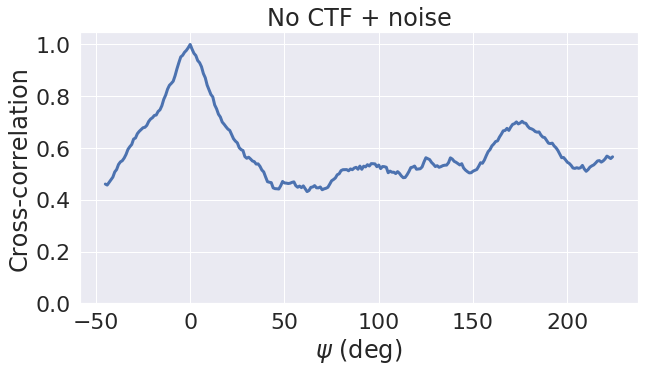

In [1354]:
xc_noise = compute_xc(m4noisyf, rots, p1=p)

sns.set(font_scale=2)
f, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(angles, xc_noise / np.max(xc_noise), linewidth=3)
# ax.plot(angles, xcl / np.max(xcl), linewidth=3)
# ax.plot(a,xc[:,2] / np.max(xc[:,0,]))
ax.set_title("No CTF + noise")
ax.set_ylim((0.,1.05))
ax.set_ylabel("Cross-correlation")
ax.set_xlabel(u"$\psi$ (deg)")

Text(0.5,0,u'$\\psi$ (deg)')

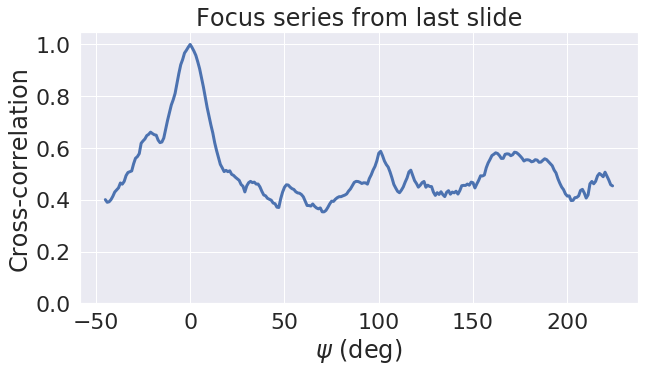

In [1362]:
xc_noise_ctfs = compute_xc(m4noisyf, rots, p1=p,
                           c=defocus_series2d(s, [5000, 7500, 10000], [10, 20, 50]))


sns.set(font_scale=2)
f, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(angles, xc_noise_ctfs / np.max(xc_noise_ctfs), linewidth=3)
# ax.plot(a,xc[:,2] / np.max(xc[:,0,]))
ax.set_ylim((0.,1.05))
ax.set_title("Focus series from last slide")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel(u"$\psi$ (deg)")

Text(0.5,0,u'$\\psi$ (deg)')

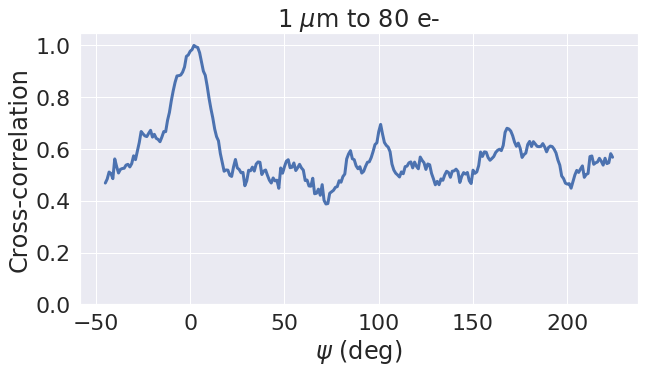

In [1364]:
xc_noise_ctf = compute_xc(m4noisyf, rots, p1=p,
                          c=defocus_series2d(s, [10000], [80]))

sns.set(font_scale=2)
f, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(angles, xc_noise_ctf / np.max(xc_noise_ctf), linewidth=3)
# ax.plot(a,xc[:,2] / np.max(xc[:,0,]))
ax.set_ylim((0.,1.05))
ax.set_title("1 $\mu$m to 80 e-")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel(u"$\psi$ (deg)")

In [939]:
test = defocus_series2d(s, [10000], [80])

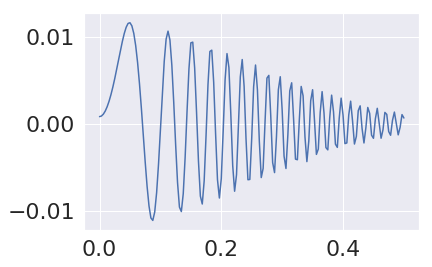

In [940]:
plt.plot(s[0], test[0])

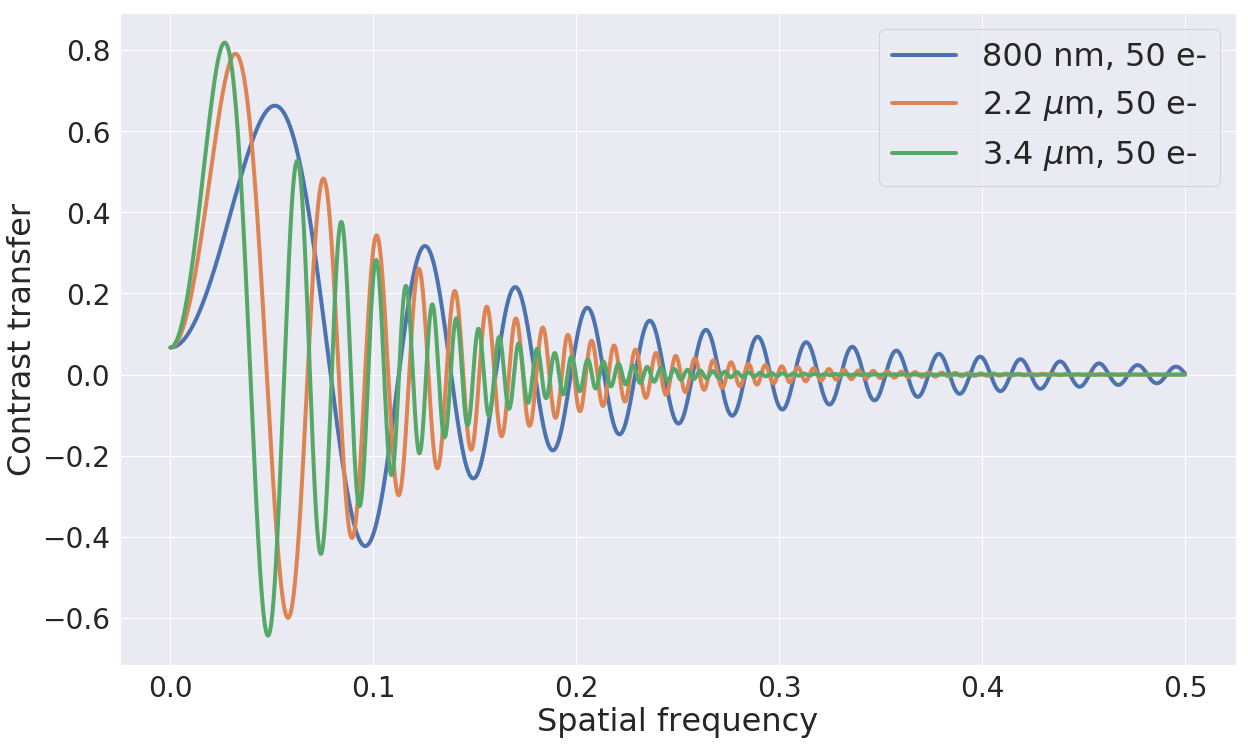

In [1442]:
f, ax = plt.subplots(1, figsize=(20,12))
plt.plot(space, ctf_ifunc1d_dose(space, 8000, 50, phase_flip=False) / 50, linewidth=4)
plt.plot(space, (ctf_ifunc1d_dose(space, 22000, 50, phase_flip=False) ) / 50, linewidth=4)
ax.plot(space, (ctf_ifunc1d_dose(space, 32000, 50, phase_flip=False)) / 50, linewidth=4)
plt.legend(["800 nm, 50 e-", "2.2 $\mu$m, 50 e-", "3.4 $\mu$m, 50 e-"], fontsize=32)
ax.set_xlabel("Spatial frequency", fontsize=32)
ax.set_ylabel("Contrast transfer", fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=28)

(-0.7228920647146259, 0.8957852750098387)

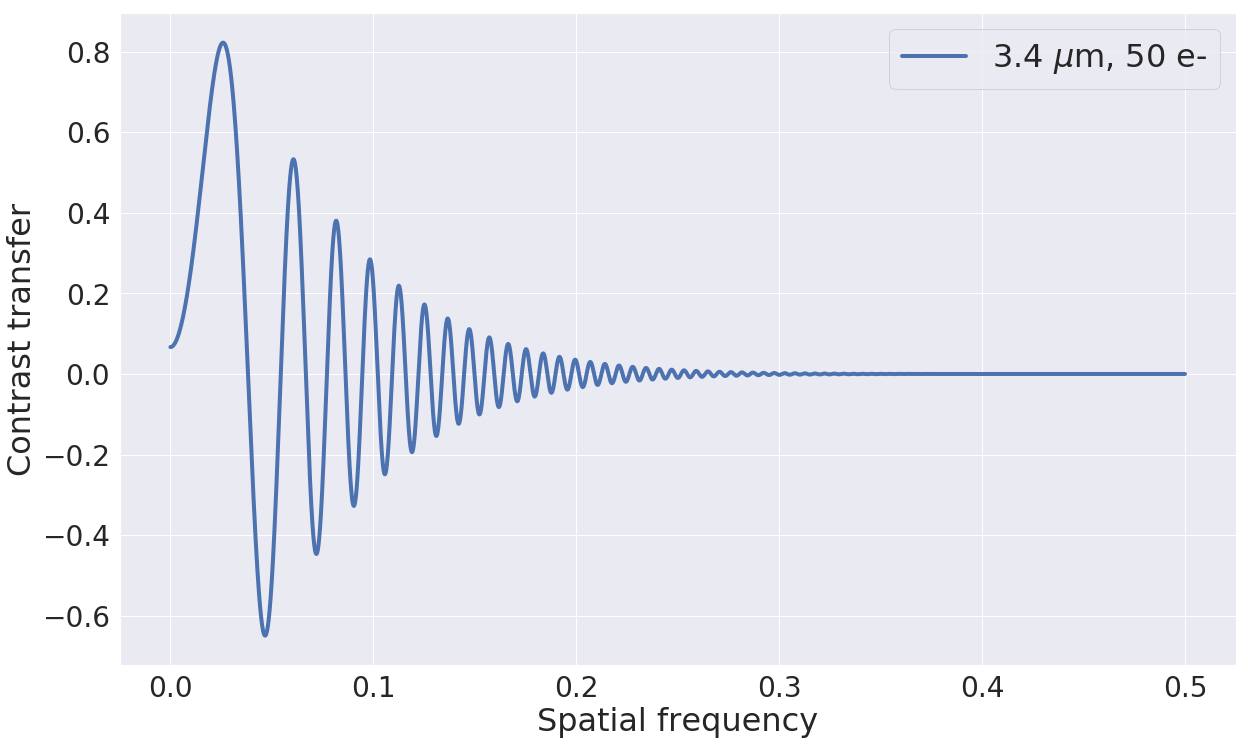

In [1490]:
f, ax = plt.subplots(1, figsize=(20,12))
plt.plot(space, ctf_ifunc1d_dose(space, 34000, 50, phase_flip=False, phase=0) / 50, linewidth=4)
# plt.plot(space, (ctf_ifunc1d_dose(space, 10000, 50, phase_flip=False, phase=90)) / 50, linewidth=4)
# plt.legend(["800 nm, 50 e-", "with 90$\degree$ shift"], fontsize=32)
# plt.legend(["800 nm, 50 e-"], fontsize=32)
plt.legend(["3.4 $\mu$m, 50 e-"], fontsize=32)
ax.set_xlabel("Spatial frequency", fontsize=32)
ax.set_ylabel("Contrast transfer", fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.set_ylim((-0.7228920647146259, 0.8957852750098387))

(-0.5863137034550592, 1.024896664686654)

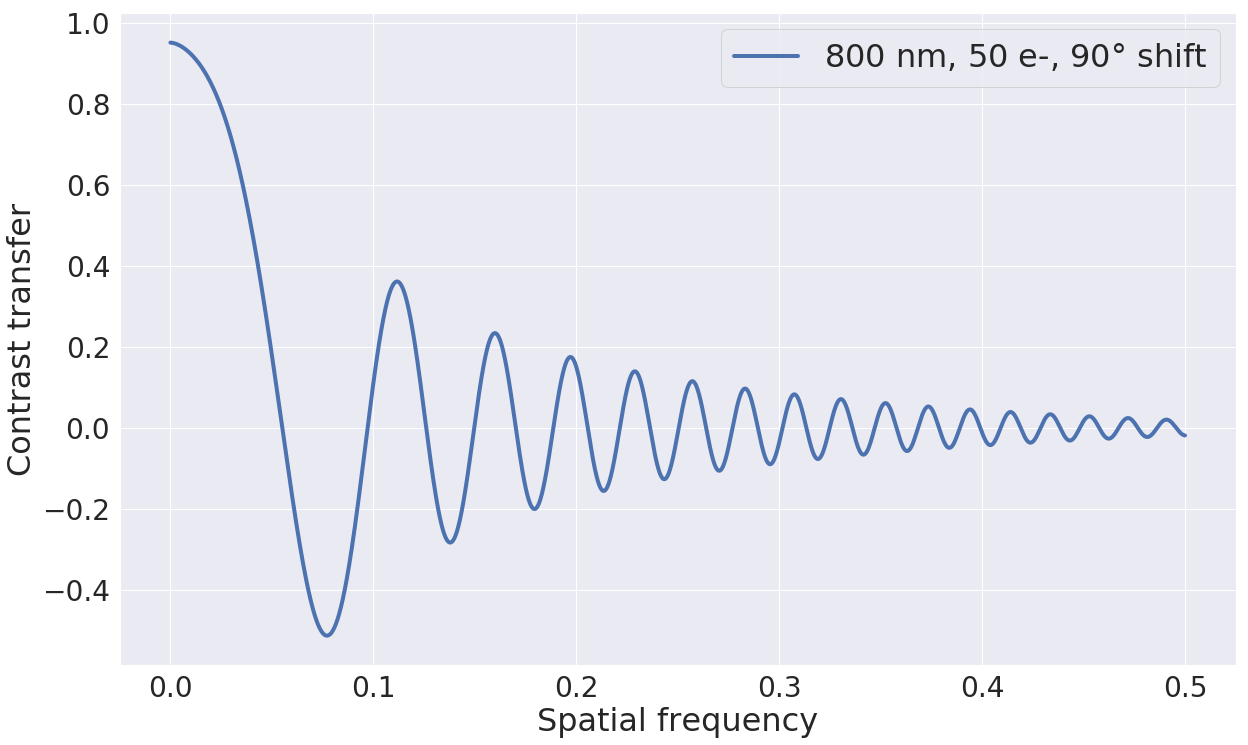

In [1487]:
f, ax = plt.subplots(1, figsize=(20,12))
plt.plot(space, ctf_ifunc1d_dose(space, 8000, 50, phase_flip=False, phase=90) / 50, linewidth=4)
# plt.plot(space, (ctf_ifunc1d_dose(space, 8000, 50, phase_flip=False, phase=90) ) / 50, linewidth=4)
# ax.plot(space, (ctf_ifunc1d_dose(space, 32000, 50, phase_flip=False)) / 50, linewidth=4)
# plt.legend(["800 nm, 50 e-", "2.2 $\mu$m, 50 e-", "3.4 $\mu$m, 50 e-"], fontsize=32)
plt.legend(["800 nm, 50 e-, 90$\degree$ shift"], fontsize=32)
# plt.legend(["800 nm, 50 e-", "with 90$\degree$ shift"], fontsize=32)
ax.set_xlabel("Spatial frequency", fontsize=32)
ax.set_ylabel("Contrast transfer", fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.set_ylim((-0.5863137034550592, 1.024896664686654))